# Integrate the 3D fractional diffusion equation in a harmonic potential with a reaction zone

This notebook walks through the steps necessary to solve and analyze this differential equation

$$ \dfrac{1}{\alpha D t^{\alpha - a}} \left(  \dot\phi + \kappa \;\mathcal H(d - r)  \right) = \phi'' + 4 \dfrac{\phi'}{r} + \dfrac{1}{8a^4} r^2 \phi - \dfrac{1}{a^2} \phi + 2\dfrac{1}{r^2}\phi $$

where $\mathcal H$ is the unit step that defines the reaction zone, $\phi = \phi(r,t)$ is the concentration, $\kappa$ is the reaction rate, $D$ is the diffusion coefficient, $d$ is the width of the reaction zone, and $a$ is the width of the harmonic potential centered at the origin. This equation was derived by taking the full 3D fractional diffusion equation (with a power-law diffusivity) and keeping only the $\ell=0$ spherical harmonic, resulting in a single radial diffusion equation. In the equation above, the equilibrium distribution has already been pulled out of the term $\phi$, so that the true concentration looks like:

$$ \Phi(r,t) = \phi(r,t) \exp\left( -\frac{r^2}{4 a^2}  \right) $$

So this integrator solves for $\phi(r,t)$ and then multiplies the final solution by the equilibrium gaussian to give a concentration profile. Additionally, this code multiplies the final result by a factor of $4 \pi r^2$ in order to give a probability density, instead of a concentration profile:

$$ P(r,t) = \dfrac{4 \pi r^2}{8 a^3 \pi^{3/2}}  \phi(r,t) \exp\left( -\frac{r^2}{4 a^2}  \right) $$

**The final array "sol" returned by the integrator represents this function $P(r,t)$ in time and space **
The jumble of constants at the front normalizes the distribution. 

There's another file in this directory, *rxn_diffusion_nondim.ipynb*, that solves a slightly different parametricization of this equation where $t \rightarrow t^\alpha$

*If you are current reading an HTML file, then you are looking at a static snapshot of the .ipynb version of this file.*

### Import necessary functions and packages

In [1]:
# import matplotlib
# matplotlib.use( "agg" )
%pylab inline

import plt_fmt

# from numba import jit

from fig_annotate import *


from diffusion_integrator_funcs import *
from frac_brown import *

from brownian_integrator import *

Populating the interactive namespace from numpy and matplotlib


### Set parameters and run integrator

In [31]:
from scipy.integrate import ode

## pick parameter values
params = dict()


# # width of overall potential well. smaller this is, the stronger the forcing
# params['POT_DIAM'] = .1
# params['KAPPA'] = 4e-1
# params['DCOEFF'] = 1e-6
# # alpha less than one
# params['ALPHA']= .5

# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = 1.0
params['KAPPA'] = 4e-3
params['DCOEFF'] = 1e-3
# alpha less than one
params['ALPHA']= .5

## set integrator settings
settings = dict()

space_pts = 100
ACTUAL_LENGTH = 10*params['POT_DIAM']


# width of reactive well
params['WELL_DIAM'] = 2


time_pts = 1e6
start_time = 0.0
stop_time = 3e1



# set integrator settings
settings = dict()

dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times

# settings['times'] = time_nondim(times, params)


# r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
r = ode(nxt_step, radiff_timeop).set_integrator('lsoda', with_jacobian=True)
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = stop_time
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T


# now multiply through by the equilibrium distribution to express things in terms 
# of a radial probability density function
gauss = eq_dist(space, params['POT_DIAM'])
gauss = gauss[:, None]
sol = sol*gauss


## Plot the results

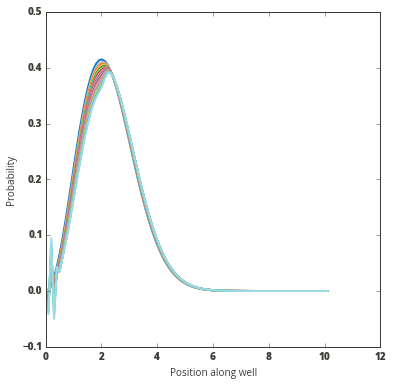

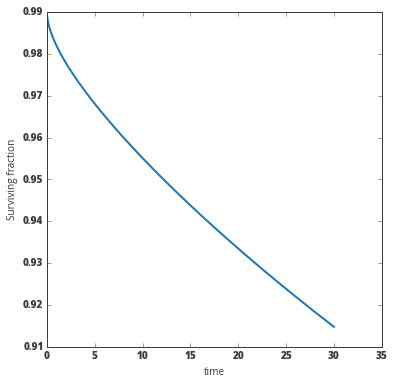

In [32]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
plot(space, sol[:,::slice_range])

# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")


#namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# integrate out space and plot surviving fraction as a function of time
figure()
total_conc = dx*sum(sol, axis = 0)
plot(times, total_conc)
ylabel("Surviving fraction")
xlabel("time")

## Plot the survival probabilities for various values of the potential diameter

The next step is to run the integrator above for a bunch of different values of the potential diameter, $a$. The code below does list that, printing out the diameter it just used as it goes. The integrator will save the full solution in space and time (for each value of $a$ tested) if the boolean *save_full_sol* is True. This takes a lot of memory and is only really useful if you want to examine full space slices at different times for signs of numerical stability issues. Otherwise, the integrator reduces the dimensionality of the data by integrating out space:

$$ P_{survival} (t) = \int P(r,t) dr $$

These vectors (indexed by timepoint) get stored in a list (indexed by the potential diameter $a$). In general, for very small values of $a$, $P_{survival} (t)$ looks like an exponential, whereas for very large values of $a$, $P_{survival} (t)$ starts to look like a stretched exponential. These limiting cases are further discussed below.

In order to estimate the average survival time at each $a$ from $P_{survival} (t)$, the distribution is just integrated,

$$ \tau_{survive} = \int P_{survival} (t) dt $$

**The key plots from this project are graphs of $\tau_{survive}$ for different values of $a^2$, which is proportional to $N$ and thus the molecular weight. This relationship is further discussed below.**


In [26]:
## pick parameter values


def timescale_vs_asquared(well_diams, params, settings, save_full_sol=False):
    '''
    Estimate the characteristic timescale of the reaction diffusion system 
    as a function of the well diameter. This code does not save the full 
    solution for memory reasons.
    
    INPUTS
    ------
    
    well_diams : array
        The different potential well widths at which to run simulations
    
    params : dict()
        All parameters values to use in the integration
        
   settings : dict()
        All of the settings for the integrator
        
        
    RETURNS
    -------
    
    outs : array
        Survival probability traces for each value in well_diams
    
    '''
    
    # make a defensive copy
    params = params.copy()
    settings = settings.copy()

    allsol = list()
    all_timesums = list()
    ct = 0

    for diam in well_diams:
        
        params['POT_DIAM'] = diam
        space_pts = 100
        ACTUAL_LENGTH = 10*params['POT_DIAM']
#         ACTUAL_LENGTH = .5
        dx = ACTUAL_LENGTH/space_pts
        space = linspace(0.0, ACTUAL_LENGTH, space_pts)
        space = space+dx
    
        settings['space'] = space
        
        # set initial equilibrium conditions
        y0 = ones(space_pts)
        
        # have to re-intialize because r is a generator expression
        r = ode(nxt_step, radiff_timeop).set_integrator('lsoda', with_jacobian=True)
        r.set_initial_value(y0, times[0])
        r.set_f_params([settings, params])
        r.set_jac_params([settings, params])
        t1 = times[-1]

        sol = list()
        while r.successful() and r.t < t1:
            r.integrate(r.t+dt)
            sol.append(r.y)
        sol = array(real(sol)).T

        gauss = eq_dist(space, params['POT_DIAM'])
        gauss = gauss[:, None]
        sol = sol*gauss
        
#         gauss = (1/sqrt(2*pi*params['POT_DIAM']**2))*exp(-space**2/(4*params['POT_DIAM']**2))
#         gauss = gauss[:, None]
#         sol = sol*gauss
#         radpart = 4*pi*(space**2)
#         radpart = radpart[:, None]
#         sol = radpart*sol


        # integrate out space
        timesum = dx*sum(sol, axis = 0)
        all_timesums.append( timesum )

        if save_full_sol:
            allsol.append( sol )
        
        # report on progress
        nn = len(well_diams)
        nnind = floor(nn/5)
        ct = mod(ct, nnind)
        ct += 1
        if ct==1: print (diam)
    
    outs = array(all_timesums)
    if save_full_sol:
        return [allsol, outs]
    else:
        return outs



def timescale_vs_asquared_vs_kappa(well_diams, kvals, params, settings):
    
    params = params.copy()
    outs = list()
    times = settings['times']
    dt = times[2] - times[1]
    
    for kval in kvals:
        params['KAPPA'] = kval
        tva = timescale_vs_asquared(well_diams, params, settings)
        outs.append( dt*sum(tva, axis=1) )
        
    return outs
        

def timescale_vs_asquared_vs_rxndiam(well_diams, rxn_diam_vals, params, settings):
    
    params = params.copy()
    outs = list()
    times = settings['times']
    dt = times[2] - times[1]
    
    for rxn_diam in rxn_diam_vals:
        params['WELL_DIAM'] = rxn_diam
        tva = timescale_vs_asquared(well_diams, params, settings)
        outs.append( dt*sum(tva, axis=1) )
        
    return outs

In [35]:
min_a_val = .001
max_a_val = .1

min_a_val = .1
max_a_val = 10
a_npts = 5


well_diams = expspace(min_a_val, max_a_val, a_npts)

out = timescale_vs_asquared(well_diams, params, settings, save_full_sol=False)


# plot the results
loglog(well_diams**2, dt*sum(out, axis=1),'.',markersize=20)
ylabel('Survival time')
xlabel('a^2 (proportional to molecular weight)')

# Now make some plots of the survival distribution itself

We're going to plot everything as $log(-log(P_{survival}(t))$ versus $log(t)$ first, so that the slope of the resulting line is simply $1/\alpha$ in the diffusion-dominated regime large $M$ or $N$. Then we're going to plot everything as $\log(P_{survival}(t))$ versus $t$, since in the reaction regime we expect to see exponential survival times. There is also a function, *janky_laplace.py*, that implements a really crude version of the Laplace transform for the discrete signal/

In [36]:
plot(log( -(log(mm)) ))

In [37]:
figure()
hold(True)
mm = out[:,::1000].T/out[:,0].T
semilogx( times[::1000], log( -(log(mm[:-1])) ))
    
    
figure()
mm=40+log(out[:, ::1000].T)
plot( times[::1000], log(mm[:-1])) 


## Now overlay multiple plots of $\tau_{survival}$ vs. $a^2$ for different values of $\kappa$

As $\kappa$ changes, we expect the location of the transition from 3/2 scaling to 2 scaling to change. So we generate many copies of the plot above to see if this occurs in the simulations

In [76]:
well_diams = expspace(.001,.1, 30)
kvals = expspace(4e-1, 1e-1, 3)
# kvals = linspace(1e-4,1e-5, 2)
outs = timescale_vs_asquared_vs_kappa(well_diams, kvals)


figure()
loglog(well_diams**2, array(outs).T)

# nmstr = 'k_1e-1_4e-1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr,params)

0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.001

## Now vary the reaction zone width while keeping $a$ fixed

In [177]:
well_diams = expspace(.001,.1, 30)
rxn_diam_vals = linspace(.01,.3,5)
# kvals = linspace(1e-4,1e-5, 2)
outs = timescale_vs_asquared_vs_rxndiam(well_diams, rxn_diam_vals)

figure()
hold(True)
loglog(well_diams**2, array(outs).T)

# nmstr = 'vary_rxnzone_kappa_4e-1_potdiam_.1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr,params)

0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.001

## Now compare to the predictions of theory

Let's try to express the Rouse and reaction timescales in terms of the units available to the integrator. The key analogy is that the solutions to the radial diffusion equation were expressed as arbitrary functions multiplied by the equilibrium distribution, which was parameterized with the potential length scale $a$


$$ P(r, t) = p(r, t) \exp\left( -\frac{r^2}{4 a^2}  \right)  $$

We compare this to the canonical equilibrium solution to the three-dimensional diffusion equaiton in a harmonic potential (see Doi and Edwards p. 63 and p. 93) 

$$ P_{eq}(r,t) \sim \exp\left( -r^2 \left(\frac{3 \pi^2}{N b^2}\right)^2  \right)  $$

From comparison, it is clear that the key relation to relate the units of this integrator to standard variable values is:

$$ a^2 = \dfrac{N b^2}{12 \pi^2}   $$

We take the longest relxation time of a Rouse polymer, $\tau = \eta \frac{N^2 b^2}{3 \pi^2 k_b T}$, plug in for $N$, and find that 

$$ \tau_{Rouse} = \eta \frac{(4)(12)\pi^2 a^4}{b^2 k_b T} $$

We know that, when $\alpha = 1$, $D = k_b T/\eta$ and so this equation can be expressed purely in terms of coefficients in the radial diffusion equation. **However, for our system with $\alpha = .5$, I'm still not totally sure how to eliminate $b^2$ (the Kuhn length) and $k_b T$ as free parameters.**

Our other timescale is taken by examining just the portion of the equilibrium gaussian distribution that sits above the reaction well, and assuming in the slow diffusion limit that probability decays exponentially in this region (without contributions due to particles diffusing into the regions). Integrating $p_{eq}(r)$ over just this finite region yeilds the reaction-dominated timescale:

$$  \tau_{rxn} = \left( \dfrac{2 \pi N b^2}{3}   \right)^\frac32 \dfrac{1}{\kappa \frac{4}{3} \pi d^3}  $$

where $d$ is the width of the reaction zone. Just for completeness, we'll write this in terms of $N$ and the Kuhn length $b$,

$$  \tau_{rxn} = \left( 8 \pi^3 a^2 \right)^\frac32 \dfrac{1}{\kappa \frac{4}{3} \pi d^3}  $$




In [27]:
def rouse_time(avals):
    '''
    Return the Rouse timescale in terms of the variables of the integrator
    Doi and Edwards p. 96, eqn. 4.25
    
    avals : array (or a single double)
        The width of the potential
    '''

    # these are the constants that I'm still not certain about
    # whatever eta is, it's going to be inversely proportional to params['DCOEFF']
    eta = 1.0 
    kuhn =1.0
    kT = 1.0
    
    numerator = eta*4*12*(pi**2)*(avals**4)
    denominator = (kuhn**2)*kT
    return numerator/denominator


def rxn_time(avals):
    '''
    Return the timescale associated with the portion of the 
    gaussian distribution that sits above the potential reacting
    
    avals : array (or a single double)
        The width of the potential
    '''
    # this is a constant that I'm still not certain about
    kuhn =1.0
    
    d = params['WELL_DIAM']
    kap = params['KAPPA']
    numerator = ( 8*(pi**3)*(avals**2) )**(3/2)
    denominator = kap*(4/3)*pi*(d**3)
    return numerator/denominator


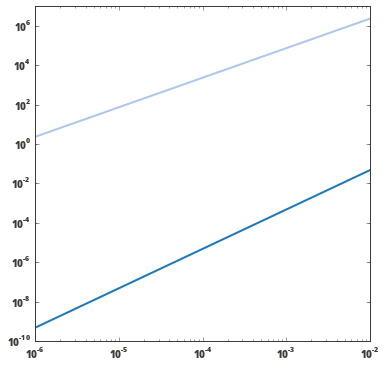

In [28]:
# Analytic predictions

figure()
# hold(True)
loglog(well_diams**2, rouse_time(well_diams))
loglog(well_diams**2, rxn_time(well_diams))

# savefig('rouse_and_rxn_times.pdf')